In [41]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as pyp
import itertools
import pandas as pd
import warnings
# from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from plotly import plotly as ply, graph_objs as go

In [42]:
warnings.filterwarnings('ignore')

## Loading the data from the dataset 

The function below named ``` dataset_loader ``` loads the data from dataset of University of Stuttgart, Germany. Here is the link to the dataset : https://www.hcilab.org/wp-content/uploads/hcilab_driving_dataset.zip  

The files are named as *participant_1.csv*, *participant_2.csv*, *participant_3.csv*, ..... so on uptil '10'. The first 5000 rows and the last '17' columns are retrieved from the each participant's data. It then **Normalizes** the data to fit them in the range **[0,1]**

In [43]:
def dataset_loader(participant):
    # Load the file 
    participant = "participant_" + str(participant)
    f = open("dataset/dataset_web/{}.csv".format(participant), "r+")
    
    # Read the names of the columns
    columns = f.readline()
    columns = columns.split(";")
    
    first_row = f.readline()
    first_row = first_row.split(";")
    first_row = first_row[5:] # Note: Remove this if time is included
    first_row = [float(num) for num in first_row]
    
    features = [np.array(first_row)]

    count = 5000
    for row in f:
        row = row.split(";")
        row = row[5:]
        row = [float(num) for num in row]
        
        features.append(row)
        if not count:
            break
        count = count - 1
    for i in range(17):
        features[:][i] = normalize([features[:][i]])[0]
        
    return np.array(features)



## My implementation of PCA
The below function ``` pca() ``` is my implementation of PCA. Although, while plotting the graphs, I'm using an external library to do PCA

In [44]:
def pca(x, dim):
    
    x_shape = np.shape(x)
    if len(x_shape) < 2:
        print("check the shape of X")
        return
    
    extract_dimension = lambda x, pos:[k[pos] for k in x]
    MUx = [np.average(extract_dimension(x, z)) for z in range(x_shape[1])]
    Cx = np.zeros([x_shape[1], x_shape[1]])
    
    for xi in x:
        Cx += np.matmul(np.transpose([xi-MUx]), [xi-MUx])
    
    eig_vals, eig_vectors = np.linalg.eig(Cx)
    eig_dict = dict(zip(eig_vals, eig_vectors))
    w=[]
    
    count = 0
    for val in sorted(eig_vals):
        w.append(eig_dict[val])
        count = count + 1
        if count == dim:
            break
    
    return np.matmul(x, np.transpose(w))
x = [[1,2,5,6,7],[2,4,1,3,5],[2,5,2,4,5]]
pca(np.array([np.array(xi) for xi in x]),3)


array([[ 7.15496226,  6.20833387,  0.81065688],
       [ 4.18817127,  2.20540336, -1.259345  ],
       [ 4.93790827,  3.12133992, -0.56675231]])

Below, I'm calling the ``` dataset_loader() ``` function and defining the ``` colors ``` variable for plotting purposes

In [45]:
features = []
num_participants = 7
for i in range(num_participants):
    features.append(dataset_loader(i+1))

colors = itertools.cycle(["green", "blue", "yellow", "pink", "purple", "red", "black"])

## Plot of the Data
The output of the cell below contains : 
* A plot of the data converted to 2-D using PCA
* A plot of the data converted to 3-D using PCA
    - This plot is very **interactive**. You can drag around and visualize the data from the plot 
    

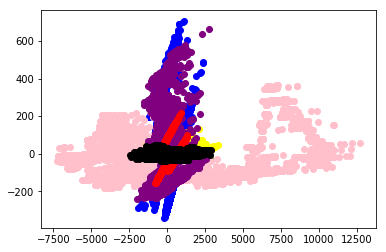

In [46]:
pca2d = PCA(n_components=2)
pca3d = PCA(n_components=3)

#### Reducing dimensions to 2-D using PCA  ####
reduced_features= []

for i in range(num_participants):
    reduced_features.append(pca2d.fit_transform(features[i]))

fig = pyp.figure()
ax = fig.add_subplot(111)

for i in range(num_participants):
    x,y = reduced_features[i].T
    cur_color = next(colors)
    ax.scatter(x, y, color=cur_color)

pyp.show()


#### Reducing dimensions to 3-D using PCA ####
data = []

for i in range(num_participants):
    pca_res = pca3d.fit_transform(features[i])
    x,y,z = pca_res.T
    trace = go.Scatter3d(x=x, y=y, z = z, mode ='markers', marker=dict(
        color=next(colors)))
    data.append(trace)


figure = go.Figure(data=data)
ply.iplot(figure)

## Dimensionality reduction using Kernel PCA
The below cell is plotting of data after reducing it to 2-D and 3-D using *Kernel* PCA. The kernel used here is **Gaussian** Kernel or **Rbf** kernel. This plot is also **interactive** and you can drag around to see different points

In [47]:
#### Kernel PCA with 'rbf' or 'Gaussian' Kernel ####
kpca2d = KernelPCA(n_components=2, kernel='rbf')
kpca3d = KernelPCA(n_components=3, kernel='rbf')

reduced_features_kpca = []
for i in range(num_participants):
    reduced_features_kpca.append(kpca2d.fit_transform(features[i]))

ax = fig.add_subplot(111)

for i in range(num_participants):
    x,y = reduced_features_kpca[i].T
    cur_color = next(colors)
    ax.scatter(x, y, color=cur_color)

pyp.show()

data = []
for i in range(num_participants):
    tsne_fit = kpca3d.fit_transform(features[i])
    x,y,z = tsne_fit.T
    trace = go.Scatter3d(x=x, y=y, z = z, mode ='markers', marker=dict(
        color=next(colors)))
    data.append(trace)


fig = go.Figure(data=data)
ply.iplot(fig)

## K-Means Algorithm
This below function implements **K-Means** algorithm for '10' cluster centers

(10, 2)


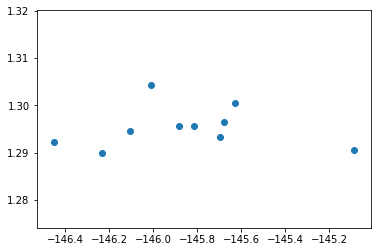

In [48]:
def k_means(features, clusters):
    
#     whitened = whiten(features)
#     print(np.shape(whitened))
    classes, _ = kmeans(features, clusters)
    return classes
    
features = dataset_loader(1)
centers = k_means(features, 10)
reduced_centers = pca(centers, 2)
print(np.shape(reduced_centers))
x,y = reduced_centers.T
pyp.scatter(x,y)
pyp.show()